## Tweet Sentiment Extraction (NLP)

This project extracts support phrases for English tweets' sentimental labels. The training data includes 27,481 tweets with sentiments and selected texts (support phrases). Sentiments divide into 40% tweets being neutral, 31% being positive and 28% being negative.

* Investigate top common words, special characters, and proportional length of support phrases
* Clean part of stop words, special characters and punctuations according to investigation results
* Compare results from Named-entity Recognition trained on cleaned and raw data for each sentiment
* Train a four-layer Neural Network embedded with Roberta for each sentiment

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib
from collections import Counter
import matplotlib.pyplot as plt
#store plots in notebook
%matplotlib inline 
import seaborn as sns; sns.set(style='white')

import math
import pickle


from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras.backend as K
#RobertaConfig
from transformers import * 
import tokenizers
from sklearn.model_selection import StratifiedKFold

#for cleaning
import nltk 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#for NER
import spacy 
import random
from spacy.util import compounding
from spacy.util import minibatch
from tqdm import tqdm
import os

from nltk.stem import PorterStemmer
ps = PorterStemmer()

#not hiding long texts
pd.set_option('max_colwidth', 40)

#for language detection
import langdetect

#filter warnings
import warnings
warnings.filterwarnings("ignore")

### Investigate and Clean Data

In [2]:
#input trainning data
train_raw = pd.read_csv("/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/input/train.csv")

In [3]:
#check distribution of missing data
train_raw[train_raw.isnull().any(axis=1)]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [4]:
#There is only one missing values in the neural category. Just drop it.
train_raw = train_raw.dropna()

In [5]:
#check it's english texts
alpha_data  = train_raw[train_raw['text'].str.contains('[a-zA-Z]')]
alpha_data['lang'] =alpha_data["text"].apply(lambda x: langdetect.detect(x))
alpha_data.head()

,textID,text,selected_text,sentiment,lang
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,en
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,negative,en
2,088c60f138,my boss is bullying me...,bullying me,negative,en
3,9642c003ef,what interview! leave me alone,leave me alone,negative,en
4,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",negative,en


In [6]:
alpha_data.loc[alpha_data.lang != "en"]
#Among 2064 rows categorized as languages other than English, they're either slangs or non-sense
#can still use 'en' to create a language class within NER

,textID,text,selected_text,sentiment,lang
7,50e14c0bb8,Soooo high,Soooo high,neutral,so
42,2e7082d1c8,MAYDAY?!,MAYDAY?!,neutral,so
46,ddf296dffa,egh blah and boooooooooooo i dunno w...,SUCKKKKKK,negative,so
54,d8ba2a99a9,romance zero is funny,romance zero is funny,positive,pl
61,a4b0888da6,haha yes,haha yes,neutral,so
...,...,...,...,...,...
27366,de241b8d04,in 7-11 w/o you,in 7-11 w/o you,neutral,cy
27373,7523a28376,hey you weirdo! haha jk! I love you!,love,positive,so
27422,b3270b06a3,"Plan, successful?","Plan, successful?",neutral,ro
27453,a01e5d1ddf,it`s beeen onee year,it`s beeen onee year,neutral,nl


In [7]:
#split original texts before counting top common words
train_raw['text_split'] = train_raw['selected_text'].apply(lambda x:x.split())
train_raw.head(5)

,textID,text,selected_text,sentiment,text_split
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,"[I`d, have, responded,, if, I, were,..."
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,negative,"[Sooo, SAD]"
2,088c60f138,my boss is bullying me...,bullying me,negative,"[bullying, me]"
3,9642c003ef,what interview! leave me alone,leave me alone,negative,"[leave, me, alone]"
4,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",negative,"[Sons, of, ****,]"


Text(0.5, 1.0, 'The most common words in positive raw tweets')

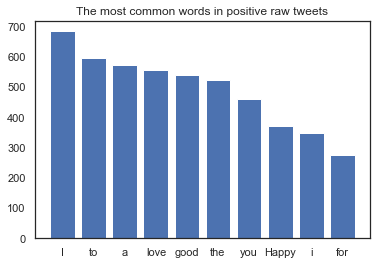

In [8]:
#check the most common words for each sentiment (raw data, positive sentiment)
top = Counter([item for sublist in train_raw.loc[train_raw.sentiment=='positive']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in positive raw tweets')
#A lot of stop words appear as the most common words of texts with positive sentiments. 
#Need to clean data then count it again.

In [9]:
#create a copy of the raw data to clean. keep the raw data to train later
train_cl=train_raw.copy()

In [10]:
#customize STOPWORDS: only pick words that don't signal any sentiment
STOPWORDS -= {"mustn't","would", "but", "only", "too", "over", "with", "down", "against", "won't", "haven't", "below", "like", "all", "can't", "not", "isn't", "wouldn't", 'off', "doesn't", 'ought', "aren't","didn't", "don't", 'no', "couldn't", 'cannot','what',"wasn't", "weren't",'above','nor', "shan't", "however", "hadn't",  "up", "why"}
def remove_stopword(x):
    return [y for y in x.split() if y not in STOPWORDS]

#apply customized STOPWORDS
train_cl.text = train_cl.text.astype(str)
train_cl.selected_text = train_cl.selected_text.astype(str)
train_cl['selected_text'] = train_cl['selected_text'].apply(lambda x: " ".join(remove_stopword(x)))
train_cl['text'] = train_cl['text'].apply(lambda x: " ".join(remove_stopword(x)))

#remove empty texts
train_cl = train_cl[(train_cl.text != '') & (train_cl.selected_text != '')]

In [11]:
train_cl = train_cl.drop(['text_split'], axis = 1)
train_cl.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d responded, I going","I`d responded, I going",neutral
1,549e992a42,Sooo SAD I will miss San Diego!!!,Sooo SAD,negative
2,088c60f138,boss bullying me...,bullying,negative
3,9642c003ef,what interview! leave alone,leave alone,negative
4,358bd9e861,"Sons ****, why couldn`t put releases...","Sons ****,",negative


In [12]:
#stemming: chop off the end of words (affixes)
train_cl['selected_text'] = train_cl['selected_text'].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))
train_cl['text'] = train_cl['text'].apply(lambda x: " ".join([ps.stem(word) for word in x.split()]))

In [13]:
train_cl.head(5)
#affixes, such as 'ing', are removed

,textID,text,selected_text,sentiment
0,cb774db0d1,"i`d responded, I go","i`d responded, I go",neutral
1,549e992a42,sooo sad I will miss san diego!!!,sooo sad,negative
2,088c60f138,boss bulli me...,bulli,negative
3,9642c003ef,what interview! leav alon,leav alon,negative
4,358bd9e861,"son ****, whi couldn`t put releas al...","son ****,",negative


In [14]:
#check texts that only contain special characters or punctuations
train_raw[~train_raw['text'].str.contains('[A-Za-z0-9]')]  

,textID,text,selected_text,sentiment,text_split
8120,4a265d8a34,****,****,negative,[****]
26005,0b3fe0ca78,?,?,neutral,[?]


In [15]:
#remove part of punctuations; 
#texts that only contain * can be curses and signal negative sentiment
def remove_periods(x):
    return [word.translate(str.maketrans({',': '', '.': '', '|': ''})) for word in x.split()]
train_cl['selected_text'] = train_cl['selected_text'].apply(lambda x: " ".join(remove_periods(x)))
train_cl['text'] = train_cl['text'].apply(lambda x: " ".join(remove_periods(x)))

In [16]:
#don't need the column of text ids
train_cl=train_cl.drop(['textID'], axis = 1)

Text(0.5, 1.0, 'The most common words in cleaned data (positive sentiments)')

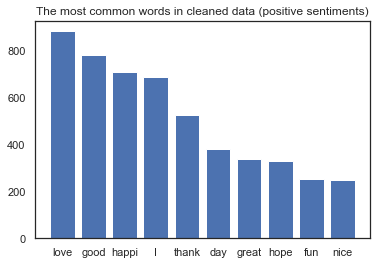

In [17]:
#check again the most common words for each sentiment (cleaned data)
train_cl['text_split'] = train_cl['selected_text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train_cl.loc[train_cl.sentiment=='positive']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in cleaned data (positive sentiments)')
#love, good, happi and thank are strong signals of being a positive text

Text(0.5, 1.0, 'The most common words in cleaned data (negative sentiments)')

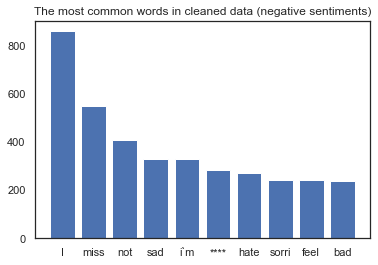

In [18]:
top = Counter([item for sublist in train_cl.loc[train_cl.sentiment=='negative']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in cleaned data (negative sentiments)')
#not, but, miss and like are strong signals of being a negative text

Text(0.5, 1.0, 'The most common words in cleaned data (neutral sentiments)')

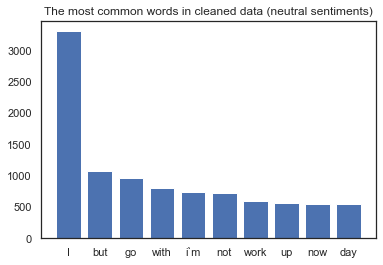

In [19]:
top = Counter([item for sublist in train_cl.loc[train_cl.sentiment=='neutral']['text_split'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
plt.bar(temp['Common_words'], temp['count'])
plt.title('The most common words in cleaned data (neutral sentiments)')
#neutral texts don't have many strong indicators of feelings

As different sentiments correspond to different most common words (different signals), this suggests I train models for different sentiment separately. Before training models, check the different length (number of words) between original and selected texts for each sentiment.

In [62]:
#check lengths of selected texts as the proportion of the length of original texts in training data. 
#compute number of words in selected text
train_raw['len_selected_text'] = train_raw['selected_text'].apply(lambda x:len(str(x).split())) 
#compute number of words in original text
train_raw['len_text'] = train_raw['text'].apply(lambda x:len(str(x).split())) 
#compute the difference between lengths. should be always positive
train_raw['difference_in_words'] = train_raw['len_text'] - train_raw['len_selected_text']
train_raw['difference_in_words'].mode(), train_raw['difference_in_words'].median(), train_raw['difference_in_words'].mean()
#0 = mode of length difference between texts and selected_texts 
#2 = median of length difference between texts and selected_texts
#5.8 = mean of length difference between texts and selected_texts. 

(0    0
 dtype: int64,
 2.0,
 5.8003639010189225)

Text(0, 0.5, 'Counts')

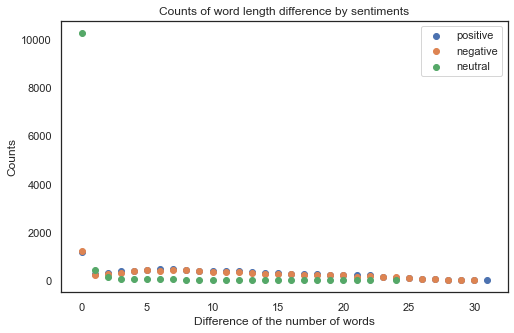

In [63]:
#Next, check difference of number of words for different sentiments
sentiments = ['positive', 'negative', 'neutral']
fig, ax = plt.subplots(figsize=(8,5))
for s in sentiments:
    temp = train_raw.loc[(train_raw.sentiment == s)]\
           .groupby('difference_in_words').agg(length_diff_count= ('difference_in_words', 'size')).reset_index()
    ax.scatter(temp['difference_in_words'], temp['length_diff_count'])
    ax.legend(sentiments)
ax.set_title('Counts of word length difference by sentiments')
ax.set_xlabel('Difference of the number of words')
ax.set_ylabel('Counts')

In [21]:
#check the number of tweets for each sentiment
len(train_raw.loc[train_raw.sentiment == 'neutral']), len(train_raw.loc[train_raw.sentiment == 'positive']), len(train_raw.loc[train_raw.sentiment == 'negative'])
#almost all neutral tweets have the support phrases the same as the whole text

(11117, 8582, 7781)

In [75]:
train_cl = train_cl.drop(['text_split'], axis = 1)
train_raw = train_raw.drop(['text_split', 'len_selected_text', 'len_text', 'difference_in_words'], axis = 1)

In [78]:
train_raw.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in Sa...,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put...","Sons of ****,",negative


The above plot shows that neutral texts, different from positive and negative texts, have a significantly large amount of selected texts with the same length as the original texts. The distribution of counts of positive and negative texts are similar most of time. This confirms the previous observation: I need to train models for different sentiments separately.

### Train cleaned data with Named-entity Recognition
Train data for each sentiment separately. Take the support phrases (selected texts) as entities.

In [64]:
#define model path for each sentiment
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/model_pos'
    elif sentiment == 'negative':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/model_neg'
    else:
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/model_neu'
    return model_out_path

In [65]:
#saving paths of trained models
def save_model(output_dir, nlp, new_model_name):
    output_dir = '/Users/qingchuanlyu/Documents/Application/Projects/{output_dir}'
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [66]:
#pass model = None to train on data directly, or nl; to train on top of existing models
def train(train_data, output_dir, n_iter=10, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  #load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  #create blank Language class (not from spacy)
        print("Created blank 'en' model")
    
    
    #create the built-in pipeline components and add them to the pipeline
    #nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    #otherwise, get it to add labels
    else:
        ner = nlp.get_pipe("ner")
    
    #add labels to the 'ner'
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    #get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  #only train NER
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()
        #To train an ner model, the model has to be looped over the example for sufficient number of iterations
        #here, n_iter = 10
        for itn in tqdm(range(n_iter)):#tqdm shows a progress bar
            random.shuffle(train_data)
            #minibatch function takes size parameter to denote the batch size. 
            #use the utility function compounding to generate series of compounding values.
            #compounding(start, end, compounding factor): start * factor * factor ... till end
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            #losses: A dictionary to hold the losses against each pipeline component. 
            #Create an empty dictionary and pass it here.
            losses = {}
            for batch in batches:
                #use * for unpack in zip()
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  #batch of texts
                    annotations,  #batch of annotations
                    drop=0.5,   #dropout - make it harder to memorise data
                    losses=losses, 
                )
            
            print("Losses", losses)
    save_model(output_dir, nlp, 'st_ner')

In [67]:
#chceck if there's an empty text or selected text--cannot be used with spacy NER
np.where(train_cl.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [68]:
#define entities: support phrases, and remove extra white spaces at the beginning/end
def get_training_data(sentiment, train_df):
    train_data = []
    for index, row in train_df.iterrows():
        if row.sentiment == sentiment:
            #use strip to remove leading and trailing spaces
            selected_text = row.selected_text.strip()
            text = row.text.strip()
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data

In [79]:
#train positive tweets
sentiment = 'positive'

train_data = get_training_data(sentiment, train_cl)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [00:45<05:17, 45.34s/it]

Losses {'ner': 25736.788739059004}


 25%|██▌       | 2/8 [01:25<04:22, 43.81s/it]

Losses {'ner': 23528.080547430916}


 38%|███▊      | 3/8 [02:05<03:33, 42.71s/it]

Losses {'ner': 22666.227156140325}


 50%|█████     | 4/8 [02:47<02:50, 42.58s/it]

Losses {'ner': 21953.839725222875}


 62%|██████▎   | 5/8 [03:28<02:06, 42.00s/it]

Losses {'ner': 21568.206311614515}


 75%|███████▌  | 6/8 [04:11<01:24, 42.27s/it]

Losses {'ner': 20921.38878667863}


 88%|████████▊ | 7/8 [04:58<00:43, 43.75s/it]

Losses {'ner': 20385.057398884404}


100%|██████████| 8/8 [05:48<00:00, 43.56s/it]

Losses {'ner': 19879.090874361213}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [80]:
#train neutral tweets
sentiment = 'neutral'

train_data = get_training_data(sentiment, train_cl)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [00:53<06:14, 53.50s/it]

Losses {'ner': 6065.923520103242}


 25%|██▌       | 2/8 [01:53<05:33, 55.53s/it]

Losses {'ner': 4993.1503220444165}


 38%|███▊      | 3/8 [02:50<04:39, 55.83s/it]

Losses {'ner': 4852.670993003616}


 50%|█████     | 4/8 [03:48<03:45, 56.41s/it]

Losses {'ner': 4984.31676011499}


 62%|██████▎   | 5/8 [04:44<02:49, 56.42s/it]

Losses {'ner': 4859.370355415915}


 75%|███████▌  | 6/8 [05:39<01:51, 55.91s/it]

Losses {'ner': 4530.855946970908}


 88%|████████▊ | 7/8 [06:33<00:55, 55.57s/it]

Losses {'ner': 4401.452591465702}


100%|██████████| 8/8 [07:28<00:00, 56.07s/it]

Losses {'ner': 4435.302763551918}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [81]:
#train ne tweets
sentiment = 'negative'

train_data = get_training_data(sentiment, train_cl)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [00:45<05:17, 45.31s/it]

Losses {'ner': 24130.485537197324}


 25%|██▌       | 2/8 [01:27<04:26, 44.48s/it]

Losses {'ner': 21531.001712200203}


 38%|███▊      | 3/8 [02:05<03:31, 42.39s/it]

Losses {'ner': 19999.51426567797}


 50%|█████     | 4/8 [02:45<02:47, 41.78s/it]

Losses {'ner': 19096.220653970522}


 62%|██████▎   | 5/8 [03:25<02:03, 41.04s/it]

Losses {'ner': 18887.610484619305}


 75%|███████▌  | 6/8 [04:01<01:19, 39.76s/it]

Losses {'ner': 18134.17002244748}


 88%|████████▊ | 7/8 [04:47<00:41, 41.45s/it]

Losses {'ner': 17544.241354654434}


100%|██████████| 8/8 [05:37<00:00, 42.17s/it]

Losses {'ner': 17377.976046328782}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [ ]:
#make prediction based on trained models for each sentiment
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    #doc.ents: the named entities in the document. 
    #doc.ents returns a tuple of named entity Span objects, if the entity recognizer has been applied.
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    #if the machine doesn't recognize an entity(support phrase), then use the original text to improve Jaccard Index
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [ ]:
#compute Jaccard Index (similarity scores)
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [82]:
TRAINED_MODELS_BASE_PATH = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/'
if TRAINED_MODELS_BASE_PATH is not None:
    print("Loading Models  from ", TRAINED_MODELS_BASE_PATH)
    model_pos = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neg')
    model_neu = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neu')
        
    jaccard_score = 0
    for index, row in tqdm(train_cl.iterrows(), total=train_cl.shape[0]): #tqdm shows a progress bar
        text = row.text
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
        
    print(f'Average Jaccard Score is {jaccard_score / train_cl.shape[0]}')

Loading Models  from  /Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_cl/


100%|██████████| 27473/27473 [01:55<00:00, 237.93it/s]

Average Jaccard Score is 0.6814476358382915


### Train raw data with Named-entity Recognition
I used the same modeling approach. The only difference is now the raw data has all the original punctuations, special characters and stopping words. The purpose is to see if the Jaccard Index will be improved by including a little "noise." Leading and trailing spaces still have to be removed for modeling purposes. 

In [83]:
#redefine output path for each model within a models_raw folder
def get_model_out_path(sentiment):
    model_out_path = None
    if sentiment == 'positive':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/NER/models_raw/model_pos'
    elif sentiment == 'negative':
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/NER/models_raw/model_neg'
    else:
        model_out_path = '/Users/qingchuanlyu/Documents/Application/Projects/NER/models_raw/model_neu'
    return model_out_path

In [84]:
#train positive tweets
sentiment = 'positive'

train_data = get_training_data(sentiment, train_raw)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

  0%|          | 0/8 [00:00<?, ?it/s]

Created blank 'en' model


 12%|█▎        | 1/8 [01:03<07:22, 63.27s/it]

Losses {'ner': 34495.94609348581}


 25%|██▌       | 2/8 [02:04<06:15, 62.59s/it]

Losses {'ner': 31534.41414805119}


 38%|███▊      | 3/8 [03:04<05:09, 61.98s/it]

Losses {'ner': 29852.290283935185}


 50%|█████     | 4/8 [04:05<04:06, 61.71s/it]

Losses {'ner': 29023.090044928515}


 62%|██████▎   | 5/8 [05:07<03:05, 61.78s/it]

Losses {'ner': 28050.829018994376}


 75%|███████▌  | 6/8 [06:03<01:59, 59.82s/it]

Losses {'ner': 27570.81122575834}


 88%|████████▊ | 7/8 [07:04<01:00, 60.21s/it]

Losses {'ner': 26417.417637890263}


100%|██████████| 8/8 [08:23<00:00, 62.92s/it]

Losses {'ner': 26469.83920600991}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [85]:
#train positive tweets
sentiment = 'negative'

train_data = get_training_data(sentiment, train_raw)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

Created blank 'en' model


 12%|█▎        | 1/8 [01:00<07:05, 60.85s/it]

Losses {'ner': 31888.50084549922}


 25%|██▌       | 2/8 [01:54<05:52, 58.70s/it]

Losses {'ner': 29067.340677474087}


 38%|███▊      | 3/8 [03:06<05:12, 62.55s/it]

Losses {'ner': 27383.918844106625}


 50%|█████     | 4/8 [04:39<04:47, 71.79s/it]

Losses {'ner': 26737.240188338023}


 62%|██████▎   | 5/8 [06:19<04:01, 80.37s/it]

Losses {'ner': 25402.630098945898}


 75%|███████▌  | 6/8 [07:50<02:46, 83.35s/it]

Losses {'ner': 24267.038133249363}


 88%|████████▊ | 7/8 [09:14<01:23, 83.71s/it]

Losses {'ner': 23704.522552007526}


100%|██████████| 8/8 [10:34<00:00, 79.32s/it]

Losses {'ner': 23441.1051843297}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [86]:
#train positive tweets
sentiment = 'neutral'

train_data = get_training_data(sentiment, train_raw)
model_path = get_model_out_path(sentiment)

train(train_data, model_path, n_iter=8, model=None)

Created blank 'en' model


 12%|█▎        | 1/8 [01:41<11:47, 101.13s/it]

Losses {'ner': 7062.446562918399}


 25%|██▌       | 2/8 [03:15<09:53, 98.98s/it] 

Losses {'ner': 5464.664182666726}


 38%|███▊      | 3/8 [04:58<08:21, 100.21s/it]

Losses {'ner': 5397.69580260112}


 50%|█████     | 4/8 [06:43<06:46, 101.73s/it]

Losses {'ner': 5286.877572375808}


 62%|██████▎   | 5/8 [08:23<05:03, 101.08s/it]

Losses {'ner': 5134.323974655159}


 75%|███████▌  | 6/8 [10:05<03:23, 101.51s/it]

Losses {'ner': 5295.005934208741}


 88%|████████▊ | 7/8 [11:45<01:41, 101.05s/it]

Losses {'ner': 4919.467996960818}


100%|██████████| 8/8 [13:26<00:00, 100.78s/it]

Losses {'ner': 4914.747258997393}
Saved model to /Users/qingchuanlyu/Documents/Application/Projects/{output_dir}


In [89]:
#compute avg Jaccard Index in the same way as before with the cleaned data
TRAINED_MODELS_BASE_PATH = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_raw/'
if TRAINED_MODELS_BASE_PATH is not None:
    print("Loading Models  from ", TRAINED_MODELS_BASE_PATH)
    model_pos = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_pos')
    model_neg = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neg')
    model_neu = spacy.load(TRAINED_MODELS_BASE_PATH + 'model_neu')
        
    jaccard_score = 0
    for index, row in tqdm(train_raw.iterrows(), total=train_raw.shape[0]):
        text = row.text
        if row.sentiment == 'neutral':
            jaccard_score += jaccard(predict_entities(text, model_neu), row.selected_text)
        elif row.sentiment == 'positive':
            jaccard_score += jaccard(predict_entities(text, model_pos), row.selected_text)
        else:
            jaccard_score += jaccard(predict_entities(text, model_neg), row.selected_text) 
        
    print(f'Average Jaccard Score is {jaccard_score / train_raw.shape[0]}')

Loading Models  from  /Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/NER/models_raw/


100%|██████████| 27480/27480 [01:57<00:00, 234.11it/s]

Average Jaccard Score is 0.7794439920934414


Jaccard Score without removing punctuations, special characters and stopping words is slightly higher than that with cleaned texts (0.78 vs 0.68).

### Train data with CNN embedded with RoBERTa
RoBERTa is a complicated bi-directional encoder pre-training system, and already takes care of special characters, stopping words and punctuations. Therefore, I trained raw data with a convolutional neural network embedded with RoBERTa for each sentiment.

In [70]:
#copy raw data
train_rb = train_raw.copy()

In [84]:
#tune hyperparameters;
#initialize tuple shape
MAX_LEN = 106
#padding to put texts of different lengths in a tensor
PAD_ID = 1
#learning rate
lr = 0.012
#set up seeds
SEED = 88888
tf.random.set_seed(SEED)
np.random.seed(SEED)
#to address overfitting and overconfidence
LABEL_SMOOTHING = 0.1
Dropout_new = 0.18     
#five folds
n_split = 5            

#the input training data was sorted by sentiments
#the last index of each sentiment category
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [88]:
#pre-trained model path
PATH = '/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/TF_Roberta/'
#RoBERTa requires tokenizer
tokenizer = tokenizers.ByteLevelBPETokenizer(
    PATH+'vocab-roberta-base.json', 
    PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)

In [89]:
#token indices, numerical representations of tokens building the sequences that will be used as input by the model
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
#The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them-->which token needs to be attended
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
#token_type_ids are represented as a binary mask identifying the two types of sequence in the model, such as a question and an answer
token_type_ids = np.zeros((ct,MAX_LEN),dtype='int32')

start_tokens = np.zeros((ct,MAX_LEN),dtype='int32')
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')

for k in range(train.shape[0]):
    
    #find overlaps between texts and selected texts
    #access the k'th row
    text1 = " "+" ".join(train_rb.loc[k,'text'].split())
    text2 = " ".join(train_rb.loc[k,'selected_text'].split())
    #the lowest index of the substring: starting point of selected text in a text
    #if not found, return -1
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    #mask selected text as 1
    chars[idx:idx+len(text2)]=1 
    #tokenize texts
    enc = tokenizer.encode(text1)  
        
    #offset index of word in texts: beginning and length of words
    offsets = []; idx=0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    toks = []
    #for each word, if it's included in a selected text, append this word's index to toks
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    #generate fully encoded tokens for each row
    #extract the representative number of sentiments
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    #Besides binary indicators, add an additional token 2 at the end
    input_ids[k,:len(enc.ids)+3] = [0, s_tok] + enc.ids + [2]
    #mask padded indices
    attention_mask[k,:len(enc.ids)+3] = 1
    #for a row with a non-missing selected text
    if len(toks)>0:
        #mark the starting point of a token as the second (the first is 0)
        start_tokens[k,toks[0]+2] = 1
        end_tokens[k,toks[-1]+2] = 1

In [104]:
#define a networking model with Tensorflow
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    
    #avoid overfitting: dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    #1D operates on two signals: input and kernel (filter). sequences of 128 vectors of 2-dimensional vectors
    #padding = "same" results in padding evenly to the left/right or up/down of the input such that output has the same height/width dimension as the input
    x1 = tf.keras.layers.Conv1D(128, 2,padding='same')(x1)
    #use leaky version to avoid many dead neurons with plain rectifier
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.Conv1D(64, 2,padding='same')(x1)
    #densely connected
    x1 = tf.keras.layers.Dense(1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    #only two classes: support phrases or not. use softmax as two classes are mutually exclusive
    x1 = tf.keras.layers.Activation('softmax')(x1)
    #4 layers
    
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1])
    #Adam assigns more learning rate to sparse words and doesn't require a learning_rate to start with
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    #use binary crossentropy loss from MLE for binary prediction
    model.compile(loss='binary_crossentropy', optimizer=optimizer)

    return model

In [ ]:
#initialize starting and end points of prediction windows
preds_start = np.zeros((input_ids.shape[0], MAX_LEN))
preds_end = np.zeros((input_ids.shape[0], MAX_LEN))

#training Roberta
DISPLAY=1
for i in range(5):
    #load weights from pretrained model
    K.clear_session()
    model = build_model()
    #save as pretrained weights for future
    model.save_weights('/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/pretrained_tweet_weights/v4-roberta-%i.h5'%i)
    model.load_weights('/Users/qingchuanlyu/Documents/Application/Projects/tweet_sentiment_extraction/pretrained_tweet_weights/v4-roberta-%i.h5'%i)
    
    print('Predicting support phrases...')
    preds = model.predict([input_ids,attention_mask,token_type_ids],verbose=DISPLAY)
    #move forwards prediction windows
    preds_start += preds[0]/n_splits
    preds_end += preds[1]/n_splits

In [ ]:
#output the predicted selected texts as a new column in the training set
all = []
for k in range(input_ids.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = train.loc[k,'text']
    else:
        text1 = " "+" ".join(train.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a-1:b])
    all.append(st)
train['selected_text_predicted'] = all

In [ ]:
#compute overall Jaccard Index
jaccard_score = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    jaccard_score += jaccard(row.selected_text_predicted, row.selected_text)
    
print(f'Average Jaccard Score is {jaccard_score / train.shape[0]}')

It took a very long time to train CNN embedded with Roberta, so I moved the last three cells to an online API with a GPU accelerator.

The average Jaccard Score is 0.74 with CNN embedded with Roberta, higher than the Jaccard Index of training cleaned data with NER (0.68) and lower than the Jaccard Index of training raw data with NER (0.78). Besides, NER has a much less training time compared with that of Roberta (29 minutes vs greater than 1 hour 48 minutes without GPU). Below are the screenshots of CNN plus Roberta results with GPU (<15 minutes):

<img src = "CNN_progress_bars.png" />
<img src = "CNN_Jaccard_Index.png" />